In [2]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn ta

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 6.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 4.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 5.1 MB/s eta 0:00:0000:0100:01
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29482 sha256=dede8ee55950e7867cd13a3745a13dcff3acb2586b6d0f7649d4965c9a7000f4
  Stored in directory: /home/tharun3086/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [seaborn]2/13 [se

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import ta

In [8]:
tickers = ["GOOG", "BTC-USD"]  # Indian stock (reliance) and cryptocurrency(dogecoin)

data_dict = {}
for ticker in tickers:
    df = yf.download(ticker, period="5y", interval="1d") # yf contain ticker,tickers,download,..etc.
    df.dropna(inplace=True)
    df["Ticker"] = ticker
    data_dict[ticker] = df

# Combine into single dataframe (optional)
df_all = pd.concat(data_dict.values(), axis=0)

/tmp/ipykernel_10781/2461206591.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d") # yf contain ticker,tickers,download,..etc.
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_10781/2461206591.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period="5y", interval="1d") # yf contain ticker,tickers,download,..etc.
[*********************100%***********************]  1 of 1 completed


In [13]:
  # adding 5 indicators using ta library, single fn for adding indicators at once
def add_indicators(df):
    df = df.copy()
    try:
        close = df['Close'].squeeze()  # Ensure 1D
        df['RSI'] = ta.momentum.RSIIndicator(close=close).rsi()
        df['MACD'] = ta.trend.MACD(close=close).macd()
        df['SMA_20'] = ta.trend.SMAIndicator(close=close, window=20).sma_indicator()
        df['EMA_20'] = ta.trend.EMAIndicator(close=close, window=20).ema_indicator()
        df['ATR'] = ta.volatility.AverageTrueRange(
            high=df['High'].squeeze(),
            low=df['Low'].squeeze(),
            close=close
        ).average_true_range()
    except Exception as e:
        print(f"Error computing indicators for data: {e}")
        return None
    return df




for ticker in tickers:
    enriched_df = add_indicators(data_dict[ticker])
    if enriched_df is not None:
        data_dict[ticker] = enriched_df
    else:
        print(f"Skipping {ticker} due to indicator error.")


In [16]:
# Pick only tickers that passed indicator addition
available_tickers = [k for k, v in data_dict.items() if v is not None and all(col in v.columns for col in ['RSI', 'MACD', 'SMA_20', 'EMA_20', 'ATR'])]

if not available_tickers:
    raise Exception("No valid ticker found with all required indicators.")

# Proceed with the first valid ticker
df = data_dict[available_tickers[0]].dropna()

# Now preprocessing should work
features_to_normalize = ['Close', 'RSI', 'MACD', 'SMA_20', 'EMA_20', 'ATR']
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[features_to_normalize] = scaler.fit_transform(df[features_to_normalize])

# Time split
def time_split(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    return df[:train_end], df[train_end:val_end], df[val_end:]

train_df, val_df, test_df = time_split(df_scaled)


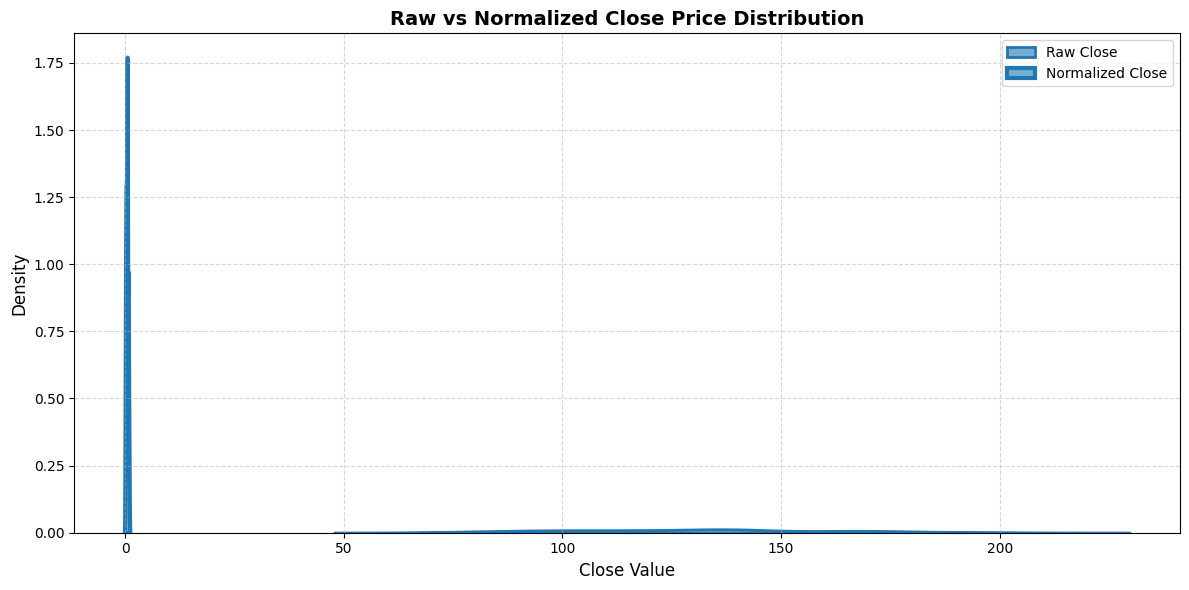

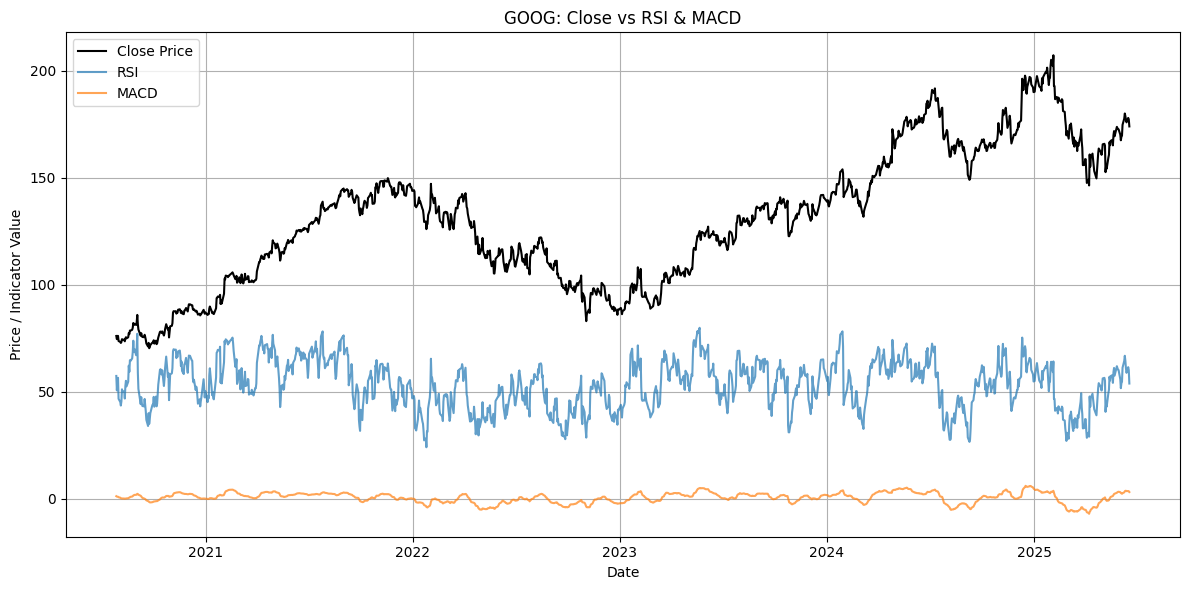

In [22]:
# b. 📈 Improved KDE Plot: Normalized vs Raw Close Price Distribution
plt.figure(figsize=(12, 6))  # Slightly larger figure for better readability

# Raw Close - Blue and bold
sns.kdeplot(df['Close'].dropna(), label='Raw Close', fill=True, color='royalblue', linewidth=2, alpha=0.6)

# Normalized Close - Orange and bold
sns.kdeplot(df_scaled['Close'].dropna(), label='Normalized Close', fill=True, color='darkorange', linewidth=3, alpha=0.6)

plt.title("Raw vs Normalized Close Price Distribution", fontsize=14, weight='bold')
plt.xlabel("Close Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='black')
plt.plot(df.index, df['RSI'], label='RSI', alpha=0.7)
plt.plot(df.index, df['MACD'], label='MACD', alpha=0.7)
plt.title(f"{df['Ticker'].iloc[0]}: Close vs RSI & MACD")  # Dynamically show ticker
plt.xlabel("Date")
plt.ylabel("Price / Indicator Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
